In [1]:
import wandb
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from utils import update_dir_name
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [2]:
training_config = {
    'n_epochs': 100,
    'p_test': 0.1,

    'optimizer': 'Muon',
    'batch_size': 100,
    'learning_rate': 0.002,
    'weight_decay': 0.0,
    'p_electrodes_per_stream': 0.5,
    
    'train_subject_trials': [("btbank1", 0), ("btbank1", 1), ("btbank2", 4), ("btbank2", 5), ("btbank3", 1), ("btbank3", 2), ("btbank7", 1), ("btbank10", 1)],
    'eval_subject_trials': [("btbank1", 2), ("btbank2", 6), ("btbank3", 0), ("btbank7", 0), ("btbank10", 0)],
    
    'data_dtype': torch.float16,

    'random_string': "X2",
}
model_config = {
    'sample_timebin_size': 256,
    'max_frequency_bin': 64,
    'max_n_timebins': 24,
    'max_n_electrodes': 128,

    'init_normalization': True, # XXX rename to a more sensible name later

    'electrode_embedding': {
        'type': 'learned', # coordinate_init, noisy_coordinate, learned
        'coordinate_noise_std': 0.0, # only relevant for noisy_coordinate type; note coordinates are normalized to be within [0,1]
        'embedding_dim': None,
    },

    'dtype': torch.bfloat16,

    'transformer': {
        'd_model': 192,
        'n_heads': 12,
        'n_layers_electrode': 5,
        'n_layers_time': 5,
        'dropout': 0.2,
    },
}
cluster_config = {
    'save_model_every_n_epochs': 20,
    'eval_model_every_n_epochs': 5,

    'wandb_project': 'mini_bfm_exp',

    'cache_subjects': True,

    'num_workers_init': 1,
    'num_workers_dataloaders': 4,
    'num_workers_eval': 4,
    'prefetch_factor': 2,
}

In [3]:
learning_rates = sorted([0.002, 0.0014, 0.001, 0.0028, 0.004, 0.0057, 0.008, 0.0011])
batch_sizes = sorted([50, 100, 200])
random_strings = ["BS_1", "BS_2", "BS_3", "BS_4", "EE_1", "EE_2", "EE_3", "EECN_1", "EECN_2", "EECN_3"]

condition_str = [f"{bs}_{lr}" for bs in batch_sizes for lr in learning_rates]

# Initialize histories dict
histories = {cs: [] for cs in condition_str}

# Generate all run IDs and collect histories
for cs in condition_str:
    for rs in random_strings:
        training_config['random_string'] = rs
        training_config['batch_size'] = int(cs.split("_")[0])
        training_config['learning_rate'] = float(cs.split("_")[1])

        run_id = update_dir_name(model_config, training_config, cluster_config)
        
        runs = api.runs("andrii-mit/mini_bfm_exp", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if '_step' not in history.columns:
                print(f"Run {run_id} has no '_step' column")
                continue
            if history['_step'].max() == 99:  # Only include if trained for full 100 epochs
                histories[cs].append(history)

for cs in condition_str:
    print(f"condition {cs}: {len(histories[cs])} runs")

condition 50_0.001: 4 runs
condition 50_0.0011: 1 runs
condition 50_0.0014: 4 runs
condition 50_0.002: 4 runs
condition 50_0.0028: 4 runs
condition 50_0.004: 4 runs
condition 50_0.0057: 1 runs
condition 50_0.008: 1 runs
condition 100_0.001: 3 runs
condition 100_0.0011: 2 runs
condition 100_0.0014: 4 runs
condition 100_0.002: 7 runs
condition 100_0.0028: 2 runs
condition 100_0.004: 3 runs
condition 100_0.0057: 2 runs
condition 100_0.008: 2 runs
condition 200_0.001: 4 runs
condition 200_0.0011: 1 runs
condition 200_0.0014: 4 runs
condition 200_0.002: 4 runs
condition 200_0.0028: 4 runs
condition 200_0.004: 4 runs
condition 200_0.0057: 1 runs
condition 200_0.008: 1 runs


In [4]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3

# Initialize results dictionary
results = {cs: {metric: [] for metric in metrics} 
          for cs in condition_str}

# Calculate means for each run
for cs in condition_str:
    for history in histories[cs]:
        for metric in metrics:
            results[cs][metric].append(history[metric].iloc[-n_last_measurements:].mean())

# Print results
for cs in condition_str:
    print(f"\nelectrode embedding type {cs}:")
    for metric in metrics:
        values = results[cs][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



electrode embedding type 50_0.001:
train_loss: 0.8750 (across 4 runs)
test_loss: 0.8955 (across 4 runs)
eval_auroc/average_speech: 0.7463 (across 4 runs)
eval_auroc/average_volume: 0.6369 (across 4 runs)

electrode embedding type 50_0.0011:
train_loss: 0.5756 (across 1 runs)
test_loss: 0.6302 (across 1 runs)
eval_auroc/average_speech: 0.7887 (across 1 runs)
eval_auroc/average_volume: 0.6751 (across 1 runs)

electrode embedding type 50_0.0014:
train_loss: 0.2953 (across 4 runs)
test_loss: 0.3937 (across 4 runs)
eval_auroc/average_speech: 0.8250 (across 4 runs)
eval_auroc/average_volume: 0.7015 (across 4 runs)

electrode embedding type 50_0.002:
train_loss: 0.1688 (across 4 runs)
test_loss: 0.2832 (across 4 runs)
eval_auroc/average_speech: 0.8483 (across 4 runs)
eval_auroc/average_volume: 0.6907 (across 4 runs)

electrode embedding type 50_0.0028:
train_loss: 0.1472 (across 4 runs)
test_loss: 0.2873 (across 4 runs)
eval_auroc/average_speech: 0.8522 (across 4 runs)
eval_auroc/average_vol

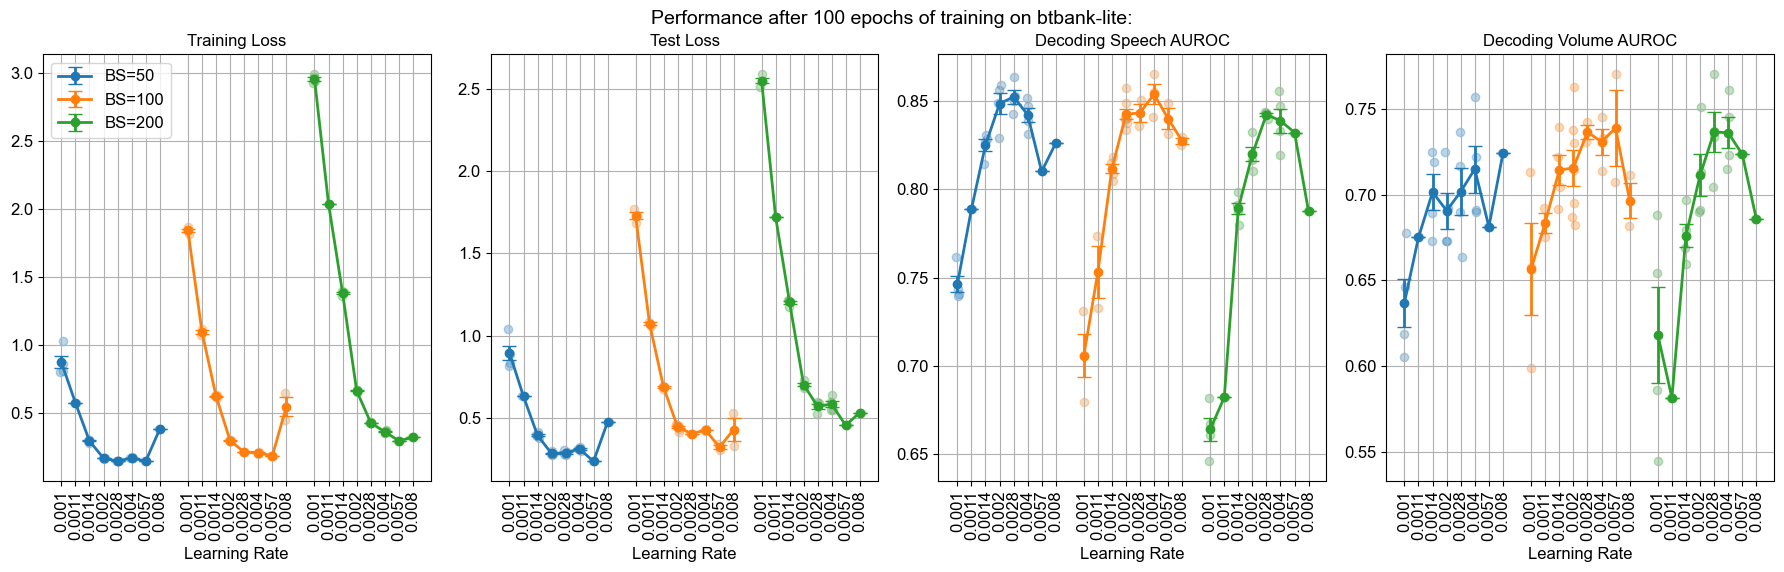

In [6]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(4.5*len(metrics), 6))

for i, metric in enumerate(metrics):
    for bs_idx, bs in enumerate(batch_sizes):
        means = []
        errors = []
        ps = []
        all_values = []
        all_ps = []
        
        # Calculate base x position for this batch size group
        base_x = bs_idx * (len(learning_rates) + 1)  # +1 for spacing between groups
        
        # Get data for each learning rate within this batch size
        for lr_idx, lr in enumerate(learning_rates):
            cs = f"{bs}_{lr}"  # Reconstruct condition string
            values = results[cs][metric] if cs in results else []
            
            if values:
                means.append(np.mean(values))
                if error_type == 'std':
                    errors.append(np.std(values))
                else:  # sem
                    errors.append(np.std(values) / np.sqrt(len(values)))
                
                x_ind = base_x + lr_idx
                ps.append(x_ind)
                
                # Store individual points
                all_values.extend(values)
                all_ps.extend([x_ind] * len(values))
        
        # Plot individual points with some jitter and transparency
        jitter = 0.1
        axes[i].scatter(
            [p + np.random.uniform(-jitter, jitter) for p in all_ps],
            all_values,
            alpha=0.3,
            color=f'C{bs_idx}',
            zorder=1
        )
        
        # Plot mean and error bars for this batch size group
        if means:  # Only plot if we have data
            error_label = f'BS={bs}'
            axes[i].errorbar(ps, means, yerr=errors, marker='o', capsize=5, 
                        color=f'C{bs_idx}', zorder=2, label=error_label,
                        linewidth=2)
    
    # Set x-ticks and labels for learning rates
    all_x_ticks = []
    all_x_labels = []
    for bs_idx, bs in enumerate(batch_sizes):
        base_x = bs_idx * (len(learning_rates) + 1)
        all_x_ticks.extend([base_x + i for i in range(len(learning_rates))])
        all_x_labels.extend([f"{lr}" for lr in learning_rates])
    
    axes[i].set_xticks(all_x_ticks, all_x_labels, rotation=90)
    axes[i].set_xlabel('Learning Rate')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    if i==0: axes[i].legend()

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig('analyses/exp_bs.pdf', bbox_inches='tight', dpi=300)
plt.show()
